In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image

import tensorflow as tf
tf.compat.v1.enable_v2_behavior()

import ddpg_agent
#from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.agents.ddpg import critic_network, actor_network
from tf_agents.agents.sac import sac_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_pybullet
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import normal_projection_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

from tf_agents.environments import suite_gym

from tf_agents.utils import nest_utils

In [2]:
tf.executing_eagerly()

True

In [3]:
env_name = 'Pendulum-v0'  # @param
num_iterations = 20000  # @param

initial_collect_steps = 1000  # @param
collect_steps_per_iteration = 1  # @param
replay_buffer_capacity = 100000  # @param

batch_size = 64  # @param
critic_learning_rate = 3e-4  # @param
actor_learning_rate = 3e-4  # @param
alpha_learning_rate = 3e-4 # @param
target_update_tau = 0.005 # @param
target_update_period = 1 #@param
gamma = 0.99 #@param
reward_scale_factor = 1.0 #@param
gradient_clipping = None #@param

actor_fc_layer_params = (256, 256)
critic_joint_fc_layer_params = (256, 256)
log_interval = 200  # @param

num_eval_episodes = 10  # @param
eval_interval = 1000  # @param

In [4]:
env = suite_gym.load(env_name)

In [5]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [6]:
observation_spec = train_env.observation_spec()
action_spec = train_env.action_spec()
critic_net = critic_network.CriticNetwork(
    (observation_spec, action_spec),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=critic_joint_fc_layer_params)

actor_net = actor_network.ActorNetwork(
    observation_spec,
    action_spec,
    fc_layer_params=actor_fc_layer_params)

In [7]:
global_step = tf.compat.v1.train.get_or_create_global_step()
tf_agent = ddpg_agent.DdpgAgent(
    train_env.time_step_spec(),
    action_spec,
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    td_errors_loss_fn=tf.compat.v1.losses.mean_squared_error,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    train_step_counter=global_step)
tf_agent.initialize()

In [8]:
eval_policy = greedy_policy.GreedyPolicy(tf_agent.policy)
collect_policy = tf_agent.collect_policy

In [9]:
def compute_avg_return(environment, policy, num_episodes=1):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

compute_avg_return(eval_env, eval_policy, num_eval_episodes)

-1362.666

In [10]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [11]:
initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
        train_env,
        collect_policy,
        observers=[replay_buffer.add_batch],
        num_steps=initial_collect_steps)
initial_collect_driver.run()

(TimeStep(step_type=<tf.Tensor: id=206046, shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>, reward=<tf.Tensor: id=206047, shape=(1,), dtype=float32, numpy=array([-8.57783], dtype=float32)>, discount=<tf.Tensor: id=206048, shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: id=206049, shape=(1, 3), dtype=float32, numpy=array([[-0.90373063, -0.42810157, -5.529249  ]], dtype=float32)>),
 ())

In [12]:
dataset = replay_buffer.as_dataset(num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)

iterator = iter(dataset)

In [13]:
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration)

In [14]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)
collect_driver.run = common.function(collect_driver.run)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, eval_policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_driver.run()

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = tf_agent.train(experience)

    step = tf_agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, eval_policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

critic_loss called


W0705 10:08:48.092117 4521391552 deprecation.py:323] From /Users/jwatts/TensorflowProjects/lib/python3.7/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


actor_loss called
train_fn
critic_loss called
actor_loss called
train_fn
step = 200: loss = 2.6481757164001465
step = 400: loss = 0.7019731998443604
step = 600: loss = 1.7004753351211548
step = 800: loss = 13.971896171569824
step = 1000: loss = 12.609968185424805
step = 1000: Average Return = -1506.5166015625
step = 1200: loss = 23.629701614379883
step = 1400: loss = 1.3743500709533691
step = 1600: loss = 1.438065767288208
step = 1800: loss = 36.47745132446289
step = 2000: loss = 2.0533456802368164
step = 2000: Average Return = -1415.6011962890625
step = 2200: loss = 26.177860260009766
step = 2400: loss = 2.414354085922241
step = 2600: loss = 1.46134614944458
step = 2800: loss = 36.40760803222656
step = 3000: loss = 2.9206013679504395
step = 3000: Average Return = -1033.634033203125
step = 3200: loss = 5.052252769470215
step = 3400: loss = 9.354452133178711
step = 3600: loss = 5.253024101257324
step = 3800: loss = 7.857862949371338
step = 4000: loss = 52.32920455932617
step = 4000: Ave

(-1577.454337310791, 0)

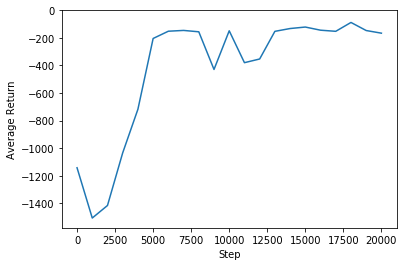

In [15]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=0)

In [51]:
time_step = eval_env.reset()
while not time_step.is_last():
    action_step = tf_agent.policy.action(time_step)
    time_step = eval_env.step(action_step.action)
    eval_py_env.render()

tf.Tensor([[1.992277]], shape=(1, 1), dtype=float32)


In [17]:
def _experience_to_transitions(experience):
    transitions = trajectory.to_transition(experience)

    transitions = tf.nest.map_structure(lambda x: tf.squeeze(x, [1]),
                                          transitions)

    time_steps, policy_steps, next_time_steps = transitions
    actions = policy_steps.action
    return time_steps, actions, next_time_steps

In [18]:
experience, unused_info = next(iterator)
time_steps, actions, next_time_steps = _experience_to_transitions(experience)

In [19]:
# CRITIC LOSS


# 1) Find td_targets by:
# a) Get target_actions by running next observations through target actor.
# b) Use target_q by running target_actions and next observations through target critic.
# c) td_target then is reward + gamma * target_q
target_actions, _ = tf_agent._target_actor_network(next_time_steps.observation, next_time_steps.step_type)

target_critic_net_input = (next_time_steps.observation, target_actions)
      
target_q_values, _ = tf_agent._target_critic_network(target_critic_net_input, next_time_steps.step_type)

td_targets = tf.stop_gradient(
    reward_scale_factor * next_time_steps.reward +
    gamma * next_time_steps.discount * target_q_values)

# 2) Find current critic Q predictions by running observations and actions
critic_net_input = (time_steps.observation, actions)

q_values, _ = tf_agent._critic_network(critic_net_input, time_steps.step_type)

# 3) Loss is between td_targets and q_values
critic_loss = tf_agent._td_errors_loss_fn(td_targets, q_values)
      
critic_loss = tf.reduce_mean(critic_loss)

print(critic_loss.numpy())

4.1898236


In [43]:
# ACTOR LOSS

# 1) predict actions from observations using actor network
actions, _ = tf_agent._actor_network(time_steps.observation, time_steps.step_type)

# 2) run those actions through the critic network to find q
with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(actions)
    q_values, _ = tf_agent._critic_network((time_steps.observation, actions), time_steps.step_type)
    actions = tf.nest.flatten(actions)
    
# 3) compute the gradient of q with respect to the actions.
dqdas = tape.gradient([q_values], actions)

actor_losses = []

# 4) loss is between the gradient of the action and the action.
for dqda, action in zip(dqdas, actions):
    print("dqda={}; action={}".format(dqda.shape, action.shape))
    loss = common.element_wise_squared_loss(tf.stop_gradient(dqda + action), action)
            
    loss = tf.reduce_mean(loss)
    
    actor_losses.append(loss)
    
actor_loss = tf.add_n(actor_losses)

print(actor_loss.numpy())

dqda=(64, 1); action=(64, 1)
6.4844923
